Names: \
Andreas Kuhn \
Milena Squindo

For installing torchsummary use `pip install torchsummary`

In [35]:
from datetime import datetime
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import matplotlib.pyplot as plt
import torch.nn.functional as F

## Multinomial Classification of MNIST 

1. Load the MNIST dataset by clicking through the first cells and see how to depict some samples. Please note that a training and a test dataset are loaded. Make sure that only the training set will be used for training and the test dataset just for evaluation (accuracy). 
2. Implement the multinomial logistic regression model by completing the code in the functions \verb|linear_trsf|, \verb|softmax|, \verb|predict|, \verb|loss_ce|, \verb|cost_ce|. 
3. Implement the mini-batch gradient descent training loop configured by number of epochs, batch size and learning rate. Implement the gradient explicitly (without autograd). Train the model with \verb|nepochs=10|, \verb|nbatch=64| and \verb|lr=0.01|. 
4. Tune learning rate and batch size and qualitatively characterise the behaviour. What is your favorite combination (learning rate, batch size, number of epochs)
5. Build and train the model with full-fledge pytorch incl. autograd. Implement a model class inheriting from $torch.nn.Module$ and use the layer functionality in the package $torch.nn$ (see lecture). Prove that you obtain the same accuracy.


#### Hints 
* Keep an eye on the shapes of the tensors (as passed into the functions and as used within the functions (and declared in the function descriptions).
* For each implemented function, run a small test with dummy input tensors (of the required shape) and check whether it outputs a tensor with expected shape and no 'nan'.
* Possibly, add \verb|assert()| statements in the code.
* For the training loop perform a training with only a single batch of size 64. Here, you should be able to obtain 100% training accuracy.

### 1. Loading the Data

Click through the cells below to load the MNIST dataset and learn how to access its samples.

#### Dataset

In [36]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [37]:
print(training_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [38]:
print(len(training_data))
x, y = training_data[5]
print(type(x), x.shape, x.dtype)
print(type(y), y)

60000
<class 'torch.Tensor'> torch.Size([1, 28, 28]) torch.float32
<class 'int'> 2


#### Depict samples

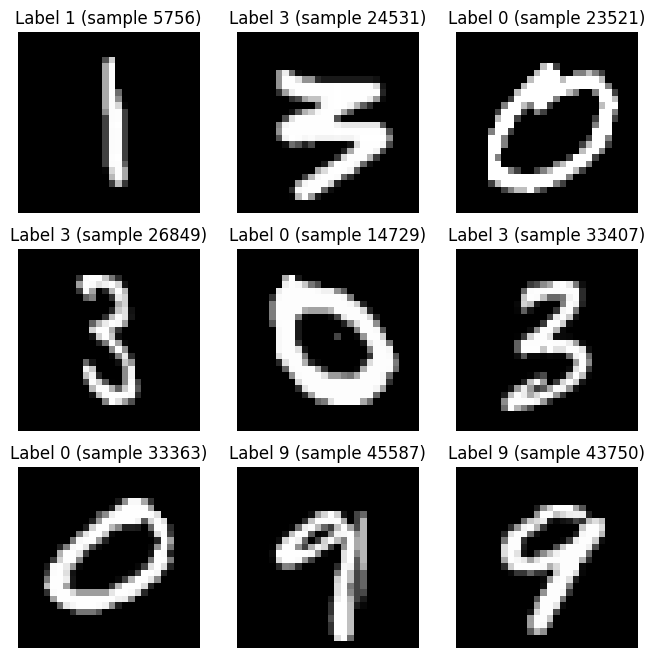

In [39]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title("Label %i (sample %i)"%(label,sample_idx))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#### Data Loader (see lecture)

In [40]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

In [41]:
data_train, labels_train = next(iter(train_dataloader))
print(f"Feature batch shape: {data_train.shape}")
print(f"Labels batch shape: {labels_train.shape}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


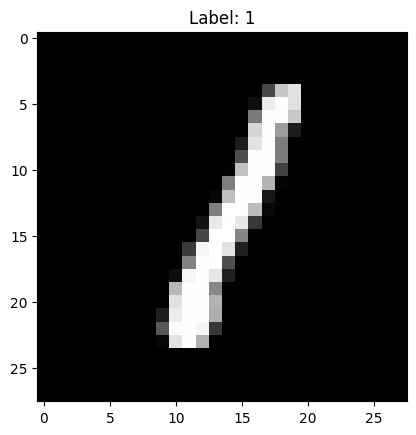

In [42]:
img = data_train[0].squeeze()
label = labels_train[0]
plt.imshow(img, cmap="gray")
plt.title(f"Label: {label}")
plt.show()

### 2. Multinomial Logistic Regression

Now, implement the model, i.e. multinomial logistic regression and the loss/cost function (cross-entropy cost).

To that end, implement the python functions below. 
All arguments are pytorch tensors with indicated shapes.

In [43]:
def linear_trsf(x,W,b):
    """
    x -- tensor with shape (nb,1,28,28)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (1,10)
    """
    # YOUR CODE (START)
    nb = x.shape[0]
    x1 = x.view(nb, -1)
    return x1@W.T + b
    # YOUR CODE (END)

def softmax(z):
    """
    z -- tensor of shape (nb,10)
    """
    # YOUR CODE (START)
    z_norm = (z-z.min()) / (z.max()- z.min())
    s = torch.exp(z_norm)
    return (s.T / torch.sum(s, dim = 1)).T
    # YOUR CODE (END)
    
def predict(x,W,b):
    """
    x -- tensor with shape (nb,1,28,28)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (1,10)
    """
    # YOUR CODE (START)
    return softmax(linear_trsf(x,W,b))
    # YOUR CODE (END)


##### TEST

In [44]:
W,b = torch.randn((10,28*28)), torch.zeros((1,10))
print(W.shape,b.shape)
u = predict(x,W,b)
print(u.shape, torch.sum(u).item())

torch.Size([10, 784]) torch.Size([1, 10])
torch.Size([1, 10]) 1.0000001192092896


#### Loss Function

In [45]:
def loss_ce(y, uhat):
    """
    y -- tensor with shape (nb,1) and possible values (0,1,2,3,4,5,6,7,8,9)
    uhat -- tensor with shape (nb,10)
    returns -- per sample loss 
    """
    # YOUR CODE (START)
    nb = y.shape[0]
    return -torch.log(uhat[torch.arange(nb), y[:]])    
    # YOUR CODE (END)

def cost_ce(y, uhat):
    """
    y -- tensor with shape (nb,1) and possible values (0,1,2,3,4,5,6,7,8,9)
    uhat -- tensor with shape (nb,10)
    return -- per batch mean of losses
    """
    # YOUR CODE (START)    
    return torch.mean(loss_ce(y, uhat)).item()
    # YOUR CODE (END)


##### TEST

In [46]:
import numpy as np
y = torch.tensor([0,1])
z = torch.tensor([[1.,2,3],[2,2,2]])
print(y.shape)
print(z.shape)
uhat = softmax(z)
print(loss_ce(y,uhat), cost_ce(y,uhat))

torch.Size([2])
torch.Size([2, 3])
tensor([1.6803, 1.0986]) 1.3894410133361816


### 3. Mini-Batch Gradient Descent

For the training, we adopt gradient descent - and start with the implementation of the gradient of the cost function (cross-entropy cost function).  

#### Gradient

In [47]:
def grad_loss_ce(x,u,uhat):
    """
    x -- tensor with shape (nb,1, 28*28)
    u -- tensor with shape (nb,10)
    uhat -- tensor with shape (nb,10)
    returns -- gradW, gradb (same dimension as W and b)
    """
    # YOUR CODE (START)
    gradW = torch.mean((uhat-u).view(-1,10,1)*x.view(-1,1,28*28), dim = 0)
    gradb =  torch.mean((uhat-u), dim = 0)  
    return gradW, gradb  
    # YOUR CODE (END)

#### Metrics - Cost, Accuracy

For tracking the progress of the training, we will use two functions: the cost and the accuracy. 

In [48]:
def metrics(X,Y,W,b):
    """
    X -- tensor with shape (nb,1,28*28)
    Y -- tensor with shape (nb,10)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (10,1)
    
    return -- cost, acc (both scalars)
    """
    # YOUR CODE (START)
    nb = Y.shape[0]
    uhat = predict(X,W,b)    
    cost = cost_ce(Y, uhat)   
    acc = torch.where(torch.argmax(uhat, dim=1) == Y, 1, 0).sum() / nb
    return cost, acc.item()
    # YOUR CODE (END)

#### Training

In [142]:
torch.manual_seed(52)
nepochs = 20
alpha = 0.001
nclasses = 10
nbatch = 8
num_batches = len(training_data)/float(nbatch)

cost_hist = []
acc_hist = []
cost_hist_test = []
acc_hist_test = []


# data loader
train_dataloader = DataLoader(training_data, batch_size=nbatch, shuffle=True)


# test data - we can load all samples for the test since it easily fits into memory
Xtest,Ytest = next(iter(DataLoader(test_data, batch_size=10000, shuffle=True))) 
nbatches = len(train_dataloader)

# initial parameters
W,b = torch.randn((10,28*28)), torch.zeros((1,10))
d0 = datetime.now()

for epoch in range(nepochs):
    cost = 0.0
    acc = 0.0
    for X,Y in train_dataloader:
        u = F.one_hot(Y, nclasses)
        uhat = predict(X,W,b)
        dW, db = grad_loss_ce(X, u, uhat)
        W = W - alpha*dW
        b = b - alpha*db
        cost_batch, acc_batch = metrics(X,Y,W,b)
        cost += cost_batch
        acc  += acc_batch

    cost /= nbatches
    acc /= nbatches

    pred = predict(Xtest, W, b)
    cost_test = cost_ce(Ytest , pred)
    acc_test = (pred.argmax(dim=1) == Ytest).type(torch.float).sum().item() / 10000

    print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
    cost_hist.append(cost)
    acc_hist.append(acc)
    cost_hist_test.append(cost_test)
    acc_hist_test.append(acc_test)
    
d = datetime.now()
print((d-d0).total_seconds()/nepochs)  

Epoch 0: 2.248189, 0.175417, 2.227135, 0.317000
Epoch 1: 2.114234, 0.432883, 2.187227, 0.537600
Epoch 2: 2.064222, 0.591100, 2.173640, 0.646000
Epoch 3: 2.042041, 0.665167, 2.166263, 0.691400
Epoch 4: 2.032458, 0.696517, 2.161568, 0.711400
Epoch 5: 2.027351, 0.713917, 2.158338, 0.723700
Epoch 6: 2.023629, 0.723100, 2.156008, 0.730500
Epoch 7: 2.021014, 0.727917, 2.154241, 0.736700
Epoch 8: 2.019534, 0.731867, 2.152882, 0.739300
Epoch 9: 2.018134, 0.734783, 2.151788, 0.742000
Epoch 10: 2.017203, 0.736650, 2.150882, 0.743500
Epoch 11: 2.015976, 0.738133, 2.150134, 0.745400
Epoch 12: 2.016415, 0.738750, 2.149486, 0.746400
Epoch 13: 2.015673, 0.739767, 2.149179, 0.747200
Epoch 14: 2.014858, 0.740550, 2.148971, 0.747600
Epoch 15: 2.014839, 0.741083, 2.148798, 0.748300
Epoch 16: 2.014516, 0.741567, 2.148646, 0.748800
Epoch 17: 2.014598, 0.742000, 2.148510, 0.749200
Epoch 18: 2.014281, 0.742467, 2.148397, 0.749700
Epoch 19: 2.014305, 0.742367, 2.148291, 0.750100
12.4022514


Text(0.5, 1.0, 'Accuracy')

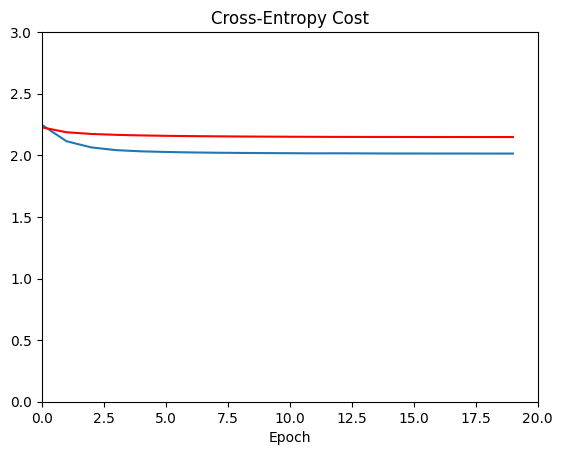

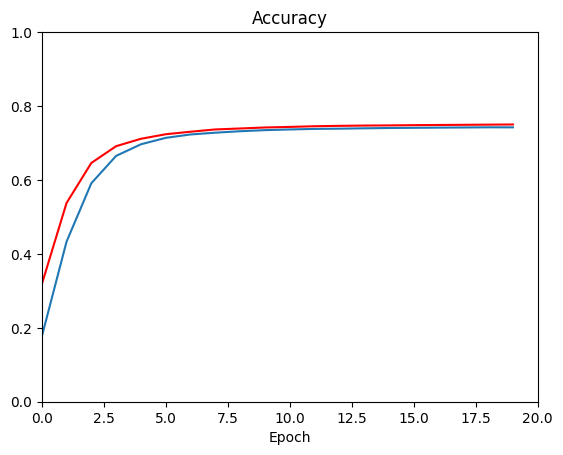

In [143]:
plt.figure(1)
plt.plot(torch.arange(nepochs), cost_hist, "-")
plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0,3)
plt.title("Cross-Entropy Cost")
plt.figure(2)
plt.plot(torch.arange(nepochs), acc_hist,"-")
plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0,1)
plt.title("Accuracy")

In [114]:
model_params = []
model_cost_train = []
model_acc_train = []
model_cost_test = []
model_acc_test = []

In [144]:
model_params.append([alpha, nbatch, nepochs])
model_cost_train.append(cost_hist)
model_acc_train.append(acc_hist)
model_cost_test.append(cost_hist_test)
model_acc_test.append(acc_hist_test)

### 4. Tune learning rate and batch size

Now analyse the training progress with five, well selected settings for each, the learning rate and the batch size.
Make sure that for each setting, a more or less "stable" test performance is achieved, i.e. a status where the test accurace is no longer expected to improve. Choose the number of epochs accordingly.

Finally, prepare suitable plots and tables to make the comparison transparent and characterize in words what you observe. 

Explain the behavior.

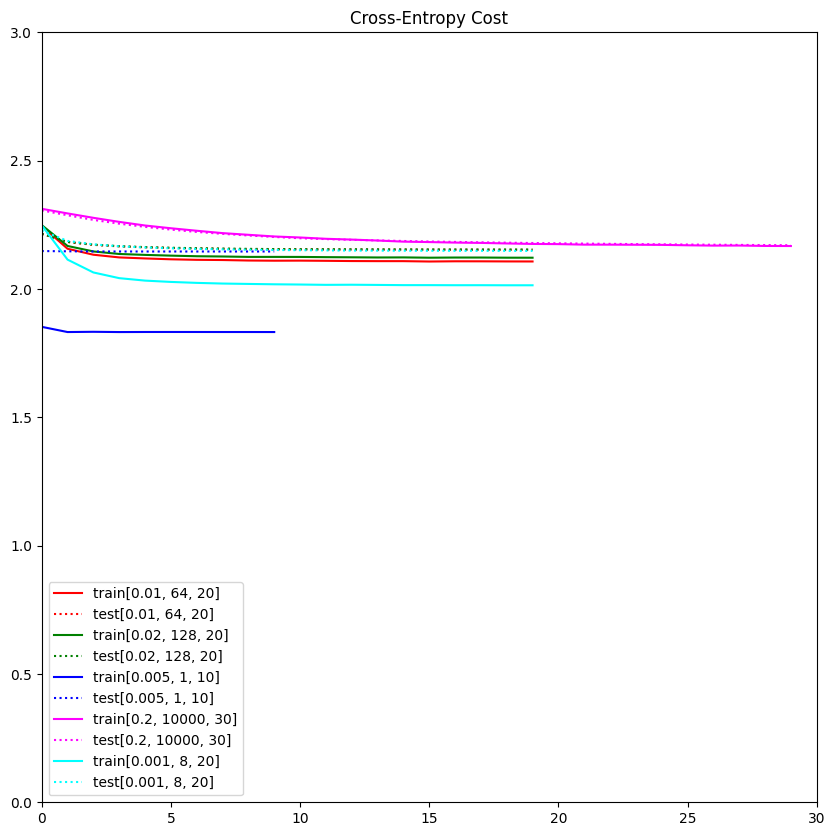

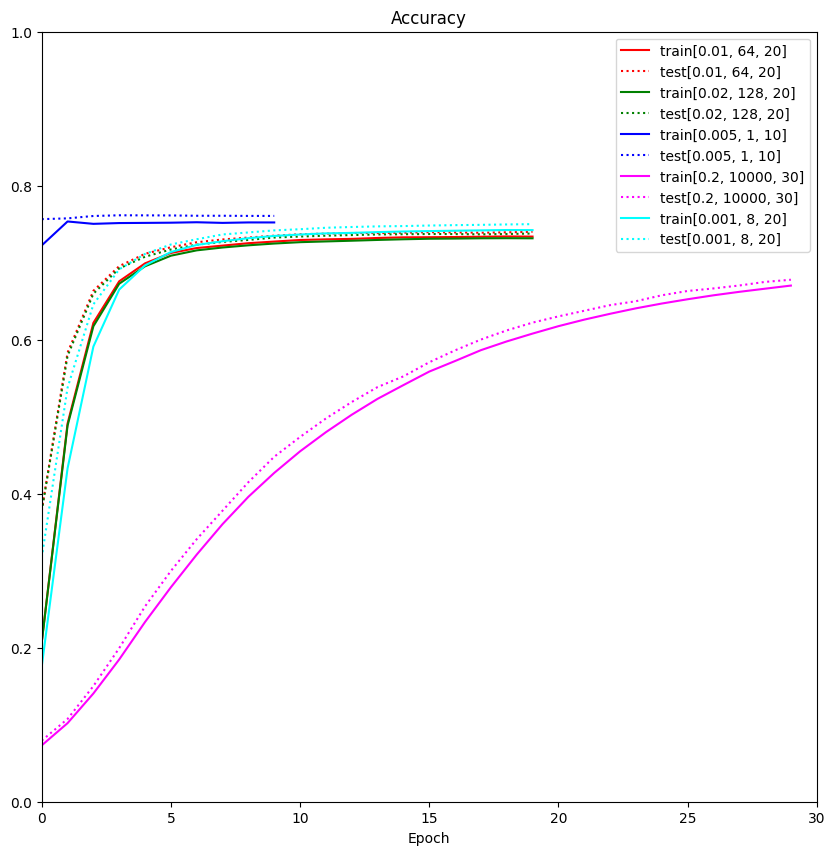

In [145]:
max_epochs = 30
i = 1
colors = ("red", "green", "blue", "magenta", "cyan")

plt.figure(1, figsize=(10,10))
for i in range(len(model_params)):
    t = torch.arange(model_params[i][2])
    plt.plot(t, model_cost_train[i], linestyle = 'solid', color = colors[i], label = f"train{model_params[i]}")
    plt.plot(t, model_cost_test[i], linestyle = 'dotted', color = colors[i], label = f"test{model_params[i]}")
    plt.xlim(0,max_epochs)
    plt.ylim(0,3)
    plt.title("Cross-Entropy Cost")
plt.legend()

plt.figure(2, figsize=(10,10))
for i in range(len(model_params)):
    t = torch.arange(model_params[i][2])
    plt.plot(t, model_acc_train[i], linestyle = 'solid', color = colors[i],label = f"train{model_params[i]}")
    plt.plot(t, model_acc_test[i], linestyle = 'dotted', color = colors[i], label = f"test{model_params[i]}")
    plt.xlabel("Epoch")
    plt.xlim(0, max_epochs)
    plt.ylim(0,1)
    plt.title("Accuracy")
plt.legend()

    

### Observations
- higher batch size means slower convergence, therefore a higher learning rate was picked (pink line)
- lower batch sizes reach better accuracy and lower loss
- with a batch size of 1 the model is close to its optimum after one epoch (blue line)
- lower batch size means a single epoch takes longer
- really high batch sizes still lead to longer time per epoch, although not as long as for really low batch sizes

### Possible explanations
- Since the weights and biases are adjusted only once per epoch, it takes way more epochs to arrive at a decent solution
- the smaller the batch size the more 'stochastic' the gradient descent becomes and every gradient used to adjust the parameters is just an approximation of the gradient of the entire model, therefore having the possibilty to escape local minima
- a batch size of 1 means the parameters get adjusted for every sample, so in this example they were adjusted 10000 times already before the first epoch was finished
- even though only a single adjustment of the parameter is made in the pink example, the vectors and matrices for computing this adjustment become huge and probably max out the computers capability

### 5. With Full-Fledge PyTorch

In [252]:
class NeuralNetwork(torch.nn.Module):
    
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear  = torch.nn.Linear(28*28, 10)
    
    def forward(self, x): # use just one linear layer and pytorch's CrossEntropyLoss
        z = self.linear(self.flatten(x))
        return z


In [253]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [254]:
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [255]:
nbatch = 1
nepochs = 10
learning_rate = 0.01

cost_hist = []
cost_hist_test = []
acc_hist = []
acc_hist_test = []

cost_ce = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10000, shuffle=True)
Xtest, Ytest = next(iter(test_loader))
size = len(training_loader.dataset)
nbatches = len(training_loader)

for epoch in range(nepochs):
    cost, acc = 0.0, 0.0
    for batch, (X, Y) in enumerate(training_loader):
        pred = model(X)
        loss = cost_ce(pred, Y)    

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += cost_ce(pred, Y).item()
        acc += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()
        
        
    cost /= nbatches
    acc /= size
    
    acc_test = 0.0
    cost_test = 0.0
    with torch.no_grad():
        for X,Y in test_loader:
            pred = model(X)
            cost_test += cost_ce(pred,Y).item()
            acc_test += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()  

    cost_test /= len(test_loader) 
    acc_test /= len(test_loader.dataset)
    
    print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
    cost_hist.append(cost)
    cost_hist_test.append(cost_test)
    acc_hist.append(acc)
    acc_hist_test.append(acc_test)


Epoch 0: 0.362505, 0.897433, 0.297387, 0.916200
Epoch 1: 0.302396, 0.914650, 0.309436, 0.911400
Epoch 2: 0.291545, 0.917583, 0.291169, 0.918100
Epoch 3: 0.284565, 0.919450, 0.295209, 0.915800
Epoch 4: 0.280605, 0.920900, 0.285715, 0.918800
Epoch 5: 0.277618, 0.922217, 0.282269, 0.920000
Epoch 6: 0.275261, 0.923017, 0.274018, 0.922100
Epoch 7: 0.271758, 0.924050, 0.288139, 0.919700
Epoch 8: 0.270581, 0.923433, 0.277746, 0.923100
Epoch 9: 0.269489, 0.924517, 0.283754, 0.922300


Text(0.5, 1.0, 'Accuracy')

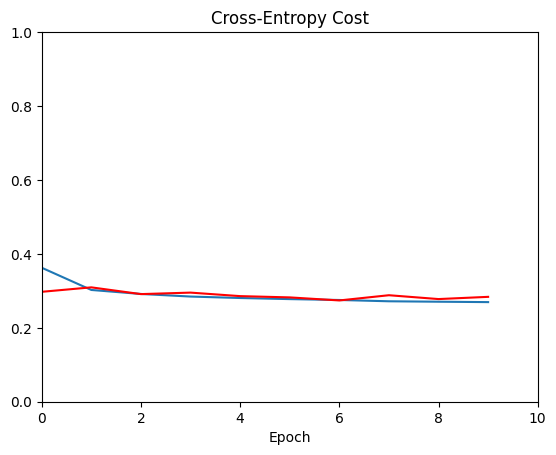

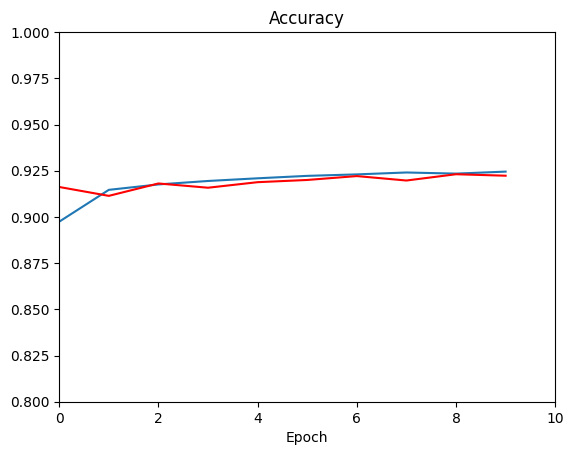

In [256]:
plt.figure(1)
plt.plot(torch.arange(nepochs), cost_hist, "-")
plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0,1)
plt.title("Cross-Entropy Cost")
plt.figure(2)
plt.plot(torch.arange(nepochs), acc_hist,"-")
plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0.8,1)
plt.title("Accuracy")